In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import importlib
import functions
import spectrogram_plotting_functions
import scipy.stats
importlib.reload(functions)
importlib.reload(spectrogram_plotting_functions)


In [ ]:
import getpass
user= (getpass.getuser())
print("Hello", user)

import glob
base='C:\\Users\\{}\\Dropbox\\CPLab'.format(user)
files = glob.glob(base+'\\all_data_mat_filtered\\*.mat')
savepath = base+'\\results\\'
print(files)

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import pickle
keyboard_dict={'98':'b','119':'w','120':'nc','49':'1','48':'0'}
#files=[f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat_filtered\\20230615_dk6_BW_context_day1.mat'] #This is just for testing purposes
events_codes_all = {}
compiled_data_all_epochs = pd.DataFrame()
compiled_data_list=[]
for file in files:
    
    # Initialize an empty DataFrame to store the results for all epochs
    ## Get the date, mouse_id and task from the file name
    base_name = os.path.basename(file)
    base_name, _ = os.path.splitext(base_name)

    date, mouse_id, task=functions.exp_params(base_name)
    print(date, mouse_id, task)
    ## Open the file
    f=h5py.File(file, 'r')
    channels = list(f.keys())
    print(channels)

    if 'Keyboard' in channels:
        events = f['Keyboard']
    elif 'keyboard' in channels:
        events = f['keyboard']
    elif 'memory' in channels:
        events = f['memory']
    elif 'Memory' in channels:
        events = f['Memory']

    events_codes=np.array(events['codes'][0])
    events_times=np.array(events['times'][0])
    events_codes_all[base_name] = events_codes
    #Generating epochs from events (epochs are basically start of a trial and end of a trial)
    epochs=functions.generate_epochs_with_first_event(events_codes, events_times)

    # Experiment Start time
    first_event=events_times[0]

    for channeli in channels:
        if "AON" in channeli or  "vHp" in channeli :
            
            channel_id=channeli
            # Extracting raw data and time
            data_all=f[channeli]
            raw_data=np.array(data_all['values']).flatten()
            raw_time = np.array(data_all['times']).flatten()
            sampling_rate = int(1/data_all['interval'][0][0])
            print(raw_data.shape, raw_time.shape, sampling_rate)
            # Normalizing the data by subtracting the mean and std of data 30sec before the first event
            normalized_data,time,data_before=functions.data_normalization(raw_data,raw_time,first_event, sampling_rate)

            # Applying a notch filter
            notch_filtered_data=functions.iir_notch(normalized_data, sampling_rate,60)
            total=notch_filtered_data
            # Extracting the bands
            beta=functions.beta_band(notch_filtered_data, sampling_rate)
            gamma=functions.gamma_band(notch_filtered_data, sampling_rate)
            theta=functions.theta_band(notch_filtered_data, sampling_rate)

            all_bands=[total,beta, gamma, theta]

            for i,epochi in enumerate(epochs):
                compiled_data = pd.DataFrame()

                door_timestamp = epochi[0][0]
                trial_type = epochi[0][1]
                dig_type = epochi[1, 1]
                print(dig_type)
                dig_timestamp = epochi[1, 0]
                print(door_timestamp,trial_type,dig_timestamp,dig_type)
                for bandi in all_bands:
                    data_complete_trial=functions.extract_complete_trial_data(bandi,time,door_timestamp,dig_timestamp,sampling_rate)
                    data_trial_before, data_trial_after=functions.extract_door_data(bandi,time,door_timestamp,sampling_rate)
                    data_dig_before, data_dig_after=functions.extract_dig_data(bandi,time,dig_timestamp,sampling_rate)

                                        # Create a DataFrame for the current bandi
                    bandi_data = pd.DataFrame({
                        'data_complete_trial': [data_complete_trial],
                        'data_trial_before': [data_trial_before],
                        'data_trial_after': [data_trial_after],
                        'data_dig_before': [data_dig_before],
                        'data_dig_after': [data_dig_after]
                    })
                    
                    # Concatenate the current bandi DataFrame with the compiled_data DataFrame along axis=1
                    compiled_data = pd.concat([compiled_data, bandi_data], axis=1)
                compiled_data.columns = ['total_complete_trial','total_pre_door', 'total_post_door', 'total_pre_odor', 'total_post_odor',
                            'beta_complete_trial','beta_pre_door', 'beta_post_door', 'beta_pre_odor', 'beta_post_odor',
                            'gamma_complete_trial','gamma_pre_door', 'gamma_post_door', 'gamma_pre_odor', 'gamma_post_odor',
                            'theta_complete_trial','theta_pre_door', 'theta_post_door', 'theta_pre_odor', 'theta_post_odor']
                compiled_data.insert(0, 'rat', mouse_id)
                compiled_data.insert(1, 'date', date)
                compiled_data.insert(2, 'experiment', task)
                compiled_data.insert(3, 'channel', channel_id)
                compiled_data.insert(4, 'trial', i)
                compiled_data.insert(5, 'timestamps', [[door_timestamp, dig_timestamp]])

                compiled_data.insert(6, 'side', keyboard_dict[str(int(trial_type))])
                compiled_data.insert(7, 'correct?', keyboard_dict[str(int(dig_type))])
                compiled_data.insert(8, 'first 30 seconds power', functions.calculate_power_1D(data_before))
                compiled_data.insert(9, 'time', [time])
                compiled_data_list.append(compiled_data)


compiled_data_all_epochs=[]
compiled_data_all_epochs.extend(compiled_data_list)
# Flatten the list of lists
compiled_data_all_epochs = pd.concat(compiled_data_all_epochs, axis=0, ignore_index=True)


In [ ]:
import sys
sys.getsizeof(compiled_data_all_epochs)

In [8]:
task_list=np.unique(compiled_data_all_epochs['experiment'])
print(task_list)
compiled_data_all_epochs['experiment'] = compiled_data_all_epochs['experiment'].apply(functions.clean_task)
task_list=np.unique(compiled_data_all_epochs['experiment'])
print(task_list)

['BWcontext' 'BWnocontext' 'nocontext' 'nocontextday2' 'nocontextos2']
['BWcontext' 'BWnocontext' 'nocontext']


In [9]:
compiled_data_all_epochs.columns

Index(['rat', 'date', 'experiment', 'channel', 'trial', 'timestamps', 'side',
       'correct?', 'first 30 seconds power', 'time', 'total_complete_trial',
       'total_pre_door', 'total_post_door', 'total_pre_odor',
       'total_post_odor', 'beta_complete_trial', 'beta_pre_door',
       'beta_post_door', 'beta_pre_odor', 'beta_post_odor',
       'gamma_complete_trial', 'gamma_pre_door', 'gamma_post_door',
       'gamma_pre_odor', 'gamma_post_odor', 'theta_complete_trial',
       'theta_pre_door', 'theta_post_door', 'theta_pre_odor',
       'theta_post_odor'],
      dtype='object')

['BWcontext', 'BWnocontext', 'nocontext']
['LFP1_AON', 'LFP2_AON', 'LFP3_AON', 'LFP4_AON']
['LFP1_vHp', 'LFP2_vHp']
-2000 6000
2000
-2000 6000
2000
-2000 6000
2000
-2000 6000
2000
['LFP1_AON', 'LFP2_AON', 'LFP3_AON', 'LFP4_AON']
['LFP1_vHp', 'LFP2_vHp']
-2000 6000
2000
-2000 6000
2000
-2000 6000
2000
-2000 6000
2000
['LFP1_AON', 'LFP2_AON', 'LFP3_AON', 'LFP4_AON']
['LFP1_vHp', 'LFP2_vHp']
-2000 6000
2000
-2000 6000
2000
-2000 6000
2000
-2000 6000
2000
['BWcontext', 'BWnocontext']
['LFP1_AON', 'LFP2_AON']
[]
-2000 6000
2000
-2000 6000
2000
['LFP4_AON']
['LFP1_vHp', 'LFP2_vHp']
-2000 6000
2000
-2000 6000
2000
-2000 6000
2000
-2000 6000
2000
['BWcontext', 'BWnocontext', 'nocontext']
['LFP3_AON', 'LFP4_AON']
['LFP1_vHp', 'LFP2_vHp']
-2000 6000
2000
-2000 6000
2000
-2000 6000
2000
-2000 6000
2000
['LFP3_AON', 'LFP4_AON']
['LFP1_vHp', 'LFP2_vHp']
-2000 6000
2000
-2000 6000
2000
-2000 6000
2000
-2000 6000
2000
['LFP1_AON', 'LFP2_AON', 'LFP3_AON', 'LFP4_AON']
['LFP1_vHp', 'LFP2_vHp']
-2000 600

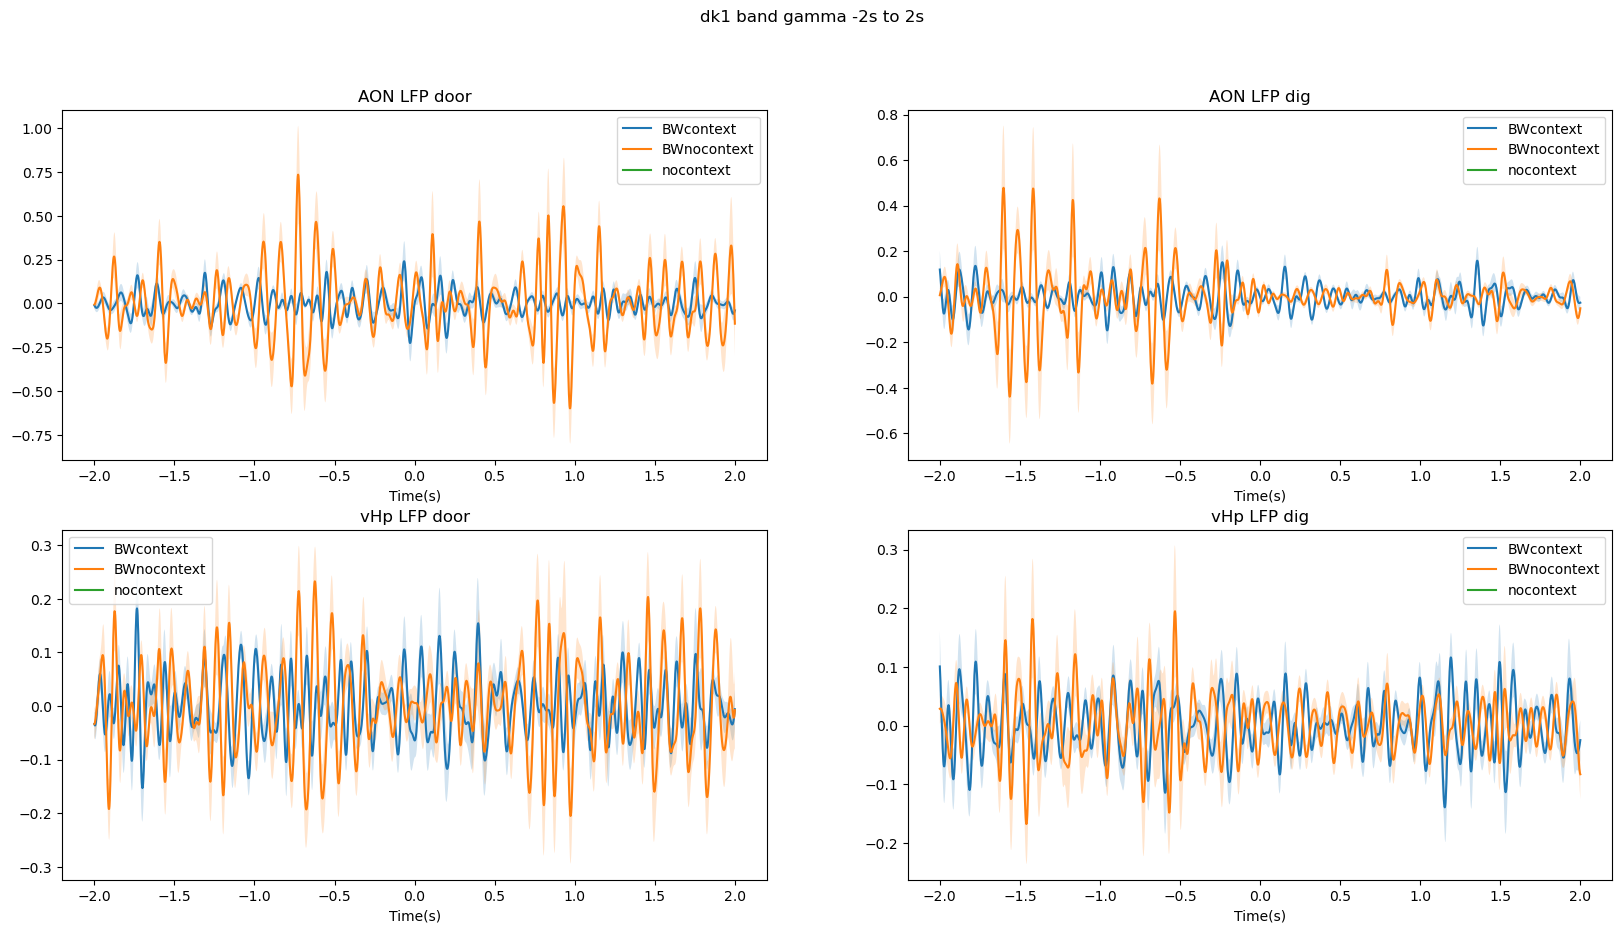

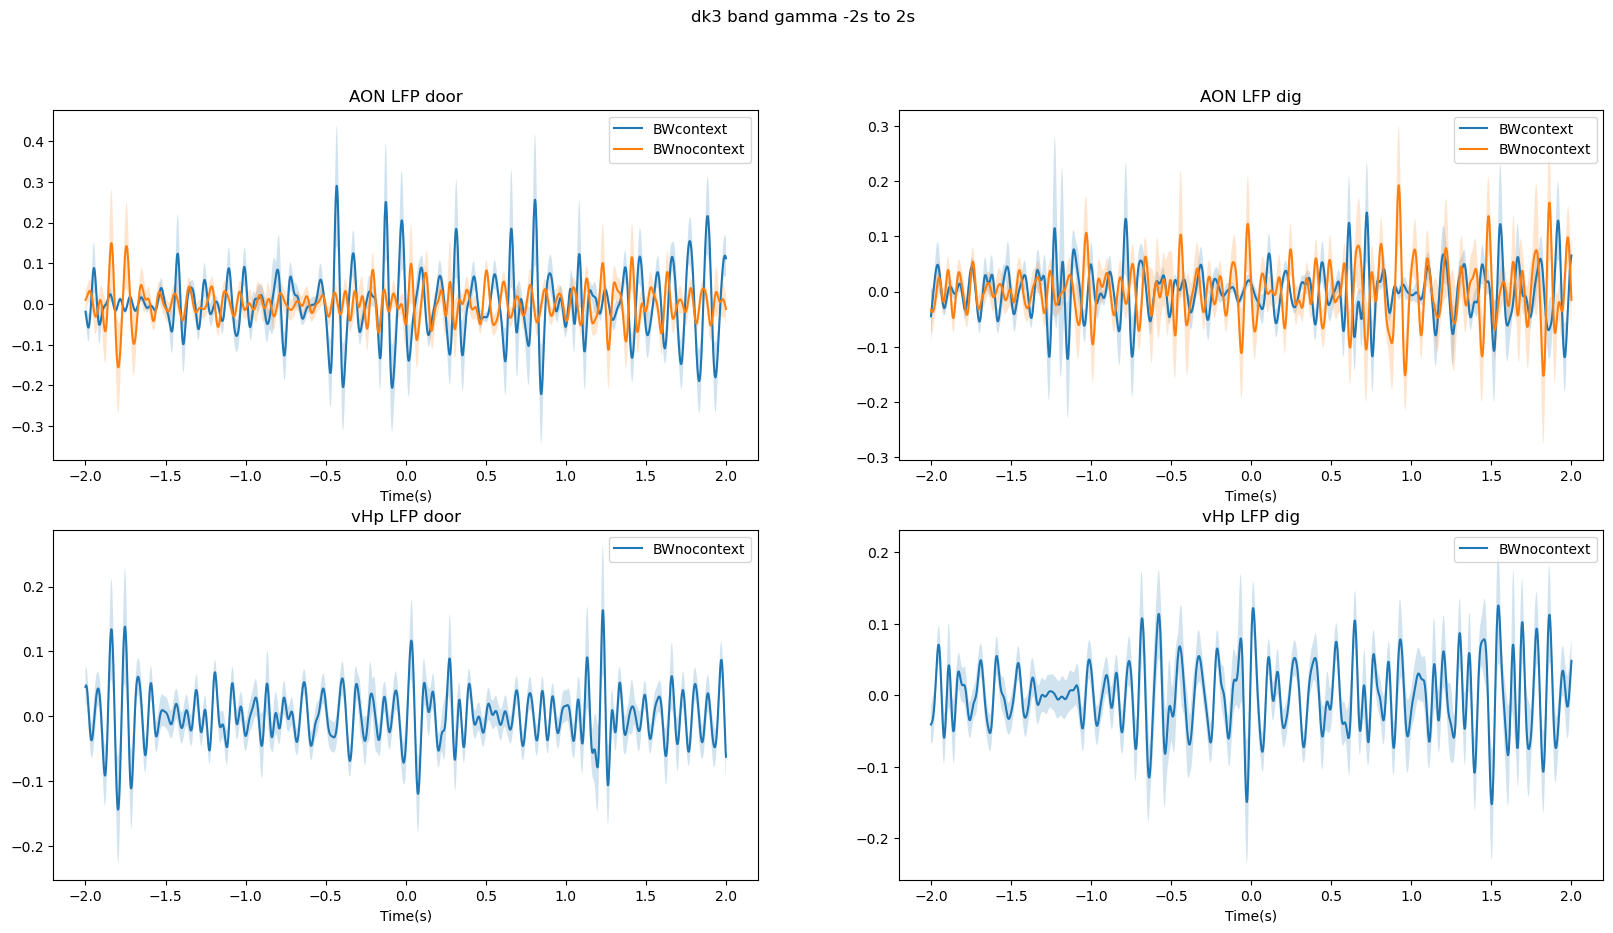

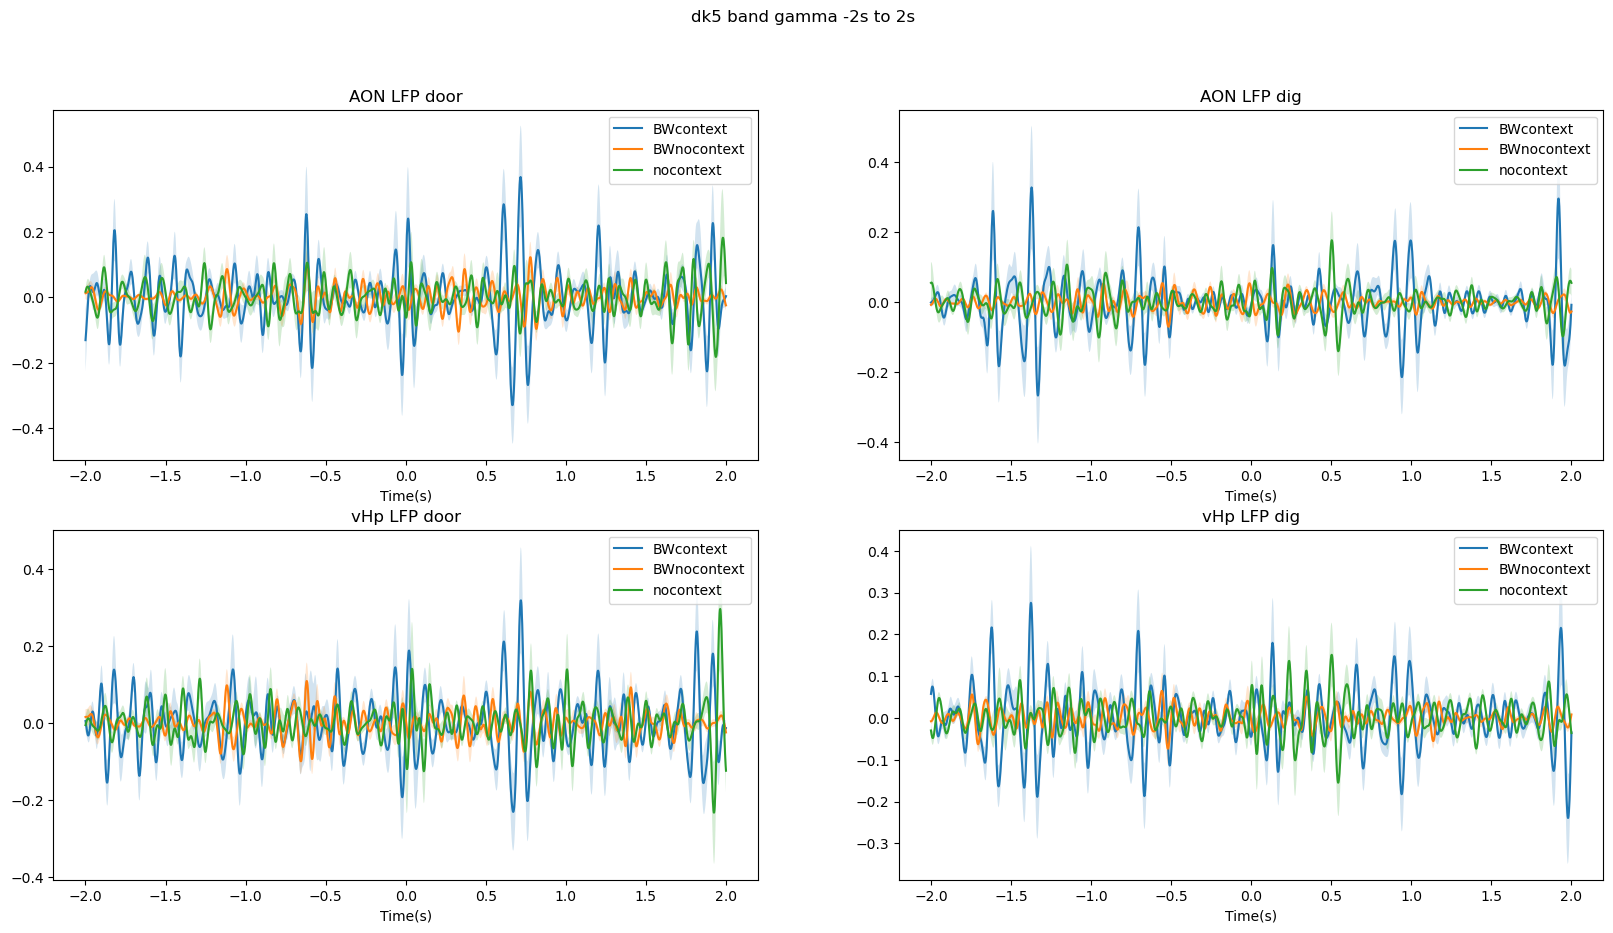

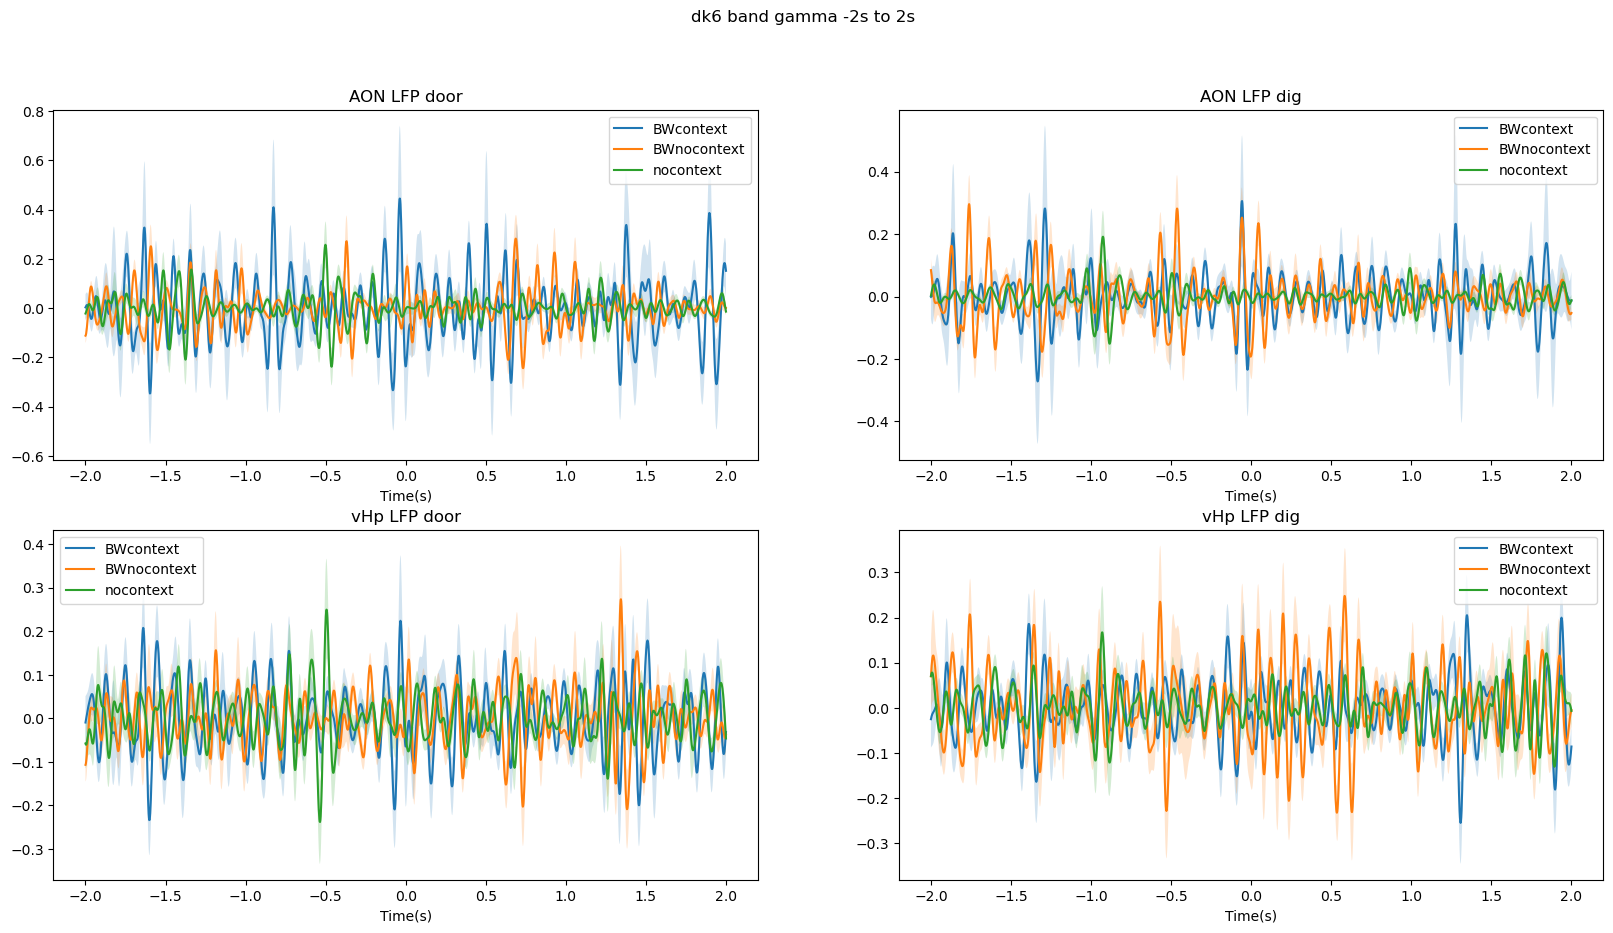

In [21]:
rat_list=list(np.unique(compiled_data_all_epochs['rat']))
window=[-2,2] #Set the window for the the waveform

all_bands=['total','beta','gamma','theta']
band='gamma' #insert the band of interest

#rat_list=['dk1']
for rati in rat_list:
    rat_dict={}
    rat_data=compiled_data_all_epochs[compiled_data_all_epochs['rat']==rati]
    rat_data=rat_data.reset_index(drop=True)
    fig, axs=plt.subplots(2,2,figsize=(20,10))
    fig.suptitle(f'{rati} band {band} {window[0]}s to {window[1]}s')
    axs=axs.flatten()
    tasks=list(np.unique(rat_data['experiment']))
    print(tasks)
    for taski in tasks:
        rat_dict['experiment']=taski
        task_data=rat_data[rat_data['experiment']==taski]
        data_channels=np.unique(task_data['channel'])
        
        aon_channels=[channel for channel in data_channels if 'AON' in channel]
        vhp_channels=[channel for channel in data_channels if 'vHp' in channel]
        aon_data_door=[]
        vhp_data_door=[]
        aon_data_dig=[]
        vhp_data_dig=[]
        print(aon_channels)
        print(vhp_channels)
        if aon_channels:
            for aon_channeli in aon_channels:
                channel_data=task_data[task_data['channel']==aon_channeli]
                #print(taski, channeli,channel_data.shape)
                door_data=np.array(np.append(channel_data[band+'_pre_door'],channel_data[band+'_post_door'],axis=0))
                dig_data=np.array(np.append(channel_data[band+'_pre_odor'],channel_data[band+'_post_odor'],axis=0))
                aon_data_door=np.append(aon_data_door,door_data)
                aon_data_dig=np.append(aon_data_dig,dig_data)
        if vhp_channels:
            for vhp_channeli in vhp_channels:
                channel_data=task_data[task_data['channel']==vhp_channeli]
                #print(taski, channeli,channel_data.shape)
                door_data=np.array(np.append(channel_data[band+'_pre_door'],channel_data[band+'_post_door'],axis=0))
                dig_data=np.array(np.append(channel_data[band+'_pre_odor'],channel_data[band+'_post_odor'],axis=0))
                vhp_data_door=np.append(vhp_data_door,door_data)
                vhp_data_dig=np.append(vhp_data_dig,dig_data)
        aon_data_dig=np.array(aon_data_dig)
        aon_data_door=np.array(aon_data_door)
        vhp_data_dig=np.array(vhp_data_dig)
        vhp_data_door=np.array(vhp_data_door)
        
        data_dict={'AON LFP door':aon_data_door,'AON LFP dig':aon_data_dig,'vHp LFP door':vhp_data_door,'vHp LFP dig':vhp_data_dig}
        for i,datai in enumerate(list(data_dict.keys())):
            ax=axs[i]
            ax.set_title(datai)
            data=data_dict[datai]
            if data.size==0:
                continue
            data_mean=np.mean(data, axis=0)
            data_sem=scipy.stats.sem(data, axis=0)
            
            l=int(len(data_mean)/2+int(window[0]*2000))
            r=int(len(data_mean)/2+int(window[1]*2000))
            print(l,r)
            #print([4000-2000*int(abs(window[0])),4000+2000*int(abs(window[1]))])
            #print(len(data_mean))
            data_mean_windowed=data_mean[l:r]
            data_sem_windowed = data_sem[l:r]

            print(len(data_mean_windowed))
            
            time_axis = np.linspace(window[0], window[1], len(data_mean_windowed))
            ax.plot(time_axis, data_mean_windowed, label=taski)
            ax.fill_between(time_axis, data_mean_windowed - data_sem_windowed, data_mean_windowed + data_sem_windowed, alpha=0.2)
            
            ax.legend()
            ax.set_xlabel('Time(s)')            
        
        

In [ ]:
channels=np.unique(waveform_df['channel'])
print(channels)
bands=['total_pre_door', 'total_post_door', 'total_pre_odor', 'total_post_odor',
                            'beta_pre_door', 'beta_post_door', 'beta_pre_odor', 'beta_post_odor',
                            'gamma_pre_door', 'gamma_post_door', 'gamma_pre_odor', 'gamma_post_odor',
                            'theta_pre_door', 'theta_post_door', 'theta_pre_odor', 'theta_post_odor']
for channel in channels:
    channel_df=waveform_df[waveform_df['channel']==channel]
    for bandi in bands:

        data=np.stack(channel_df[bandi].values)
        data_mean = np.mean(data, axis=0)
        plt.figure(figsize=(10, 5))
        
        # Plot individual rows as faint lines
        for row in data:
            plt.plot(row, color='gray', alpha=0.3)
        
        # Plot the mean as a prominent line
        plt.plot(data_mean, color='blue', linewidth=2)
        
        plt.title(f'{bandi} - Channel {channel}')
        plt.xlabel('Sample Index')
        plt.ylabel('Mean Value')
        plt.grid(True)
        plt.show()

In [ ]:
import pandas as pd
import numpy as np

channels = np.unique(waveform_df['channel'])
print(channels)
bands = ['total_pre_door', 'total_post_door', 'total_pre_odor', 'total_post_odor',
         'beta_pre_door', 'beta_post_door', 'beta_pre_odor', 'beta_post_odor',
         'gamma_pre_door', 'gamma_post_door', 'gamma_pre_odor', 'gamma_post_odor',
         'theta_pre_door', 'theta_post_door', 'theta_pre_odor', 'theta_post_odor']

for bandi in bands:
    band_df = waveform_df[[bandi]].copy()  # Extract the band column and make a copy
    band_df = pd.concat([band_df, waveform_df[['channel']]], axis=1)  # Concatenate along columns
    fig, axs=plt.subplots(len(channels),1, sharex=True)
    fig.suptitle(bandi)
    axs=axs.flatten()
    for i,channeli in enumerate(channels):
        channel_df=band_df[band_df['channel']==channeli]
        
        data=np.stack(channel_df[bandi].values)
        data_mean = np.mean(data, axis=0)
        ax=axs[i]
        # Plot individual rows as faint lines
        # for row in data:
        #     ax.plot(row, color='gray', alpha=0.3)
        
        # Plot the mean as a prominent line
        ax.plot(data_mean, color='blue', linewidth=2)
        ax.grid(True)
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Signal Amp (uV)')
        ax.set_title(f' Channel {channeli}')

    plt.tight_layout()  # Adjust the vertical space between subplots
    plt.show()
        #continue  # Placeholder for further processing

I will try to make the power spectrum

In [ ]:
from scipy.signal import welch, spectrogram

test=waveform_df['total_post_door'].iloc[0]
print(test)
f, Pxx = welch(test, fs=2000, nperseg=250, noverlap=100)
f = f[np.where(f<=100)] #select only frequencies below 100Hz
Pxx = Pxx[np.where(f<=100)]
plt.figure(figsize=(10,5))
plt.plot(f, Pxx)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')

In [ ]:
from scipy.signal import welch
import numpy as np

total_events = ['total_pre_door', 'total_post_door', 'total_pre_odor', 'total_post_odor']
spectrum_dict={}
for event in total_events:
    aon_context=[]
    aon_nocontext=[]
    vhp_context=[]
    vhp_nocontext=[]
    for i in range(len(waveform_df)):
        test = waveform_df[event].iloc[i]
        f, Pxx = welch(test, fs=2000, nperseg=400, noverlap=None)
        f = f[np.where(f <= 100)]  # select only frequencies below 100Hz
        Pxx = Pxx[np.where(f <= 100)]
        if (waveform_df['experiment'].iloc[i] == 'BWcontext') and ('AON' in waveform_df['channel'].iloc[i]):
            aon_context.append(Pxx)
        elif (waveform_df['experiment'].iloc[i] == 'BWnocontext') and ('AON' in waveform_df['channel'].iloc[i]):
            aon_nocontext.append(Pxx)
        elif (waveform_df['experiment'].iloc[i] == 'BWcontext') and ('vHp' in waveform_df['channel'].iloc[i]):
            vhp_context.append(Pxx)
        elif (waveform_df['experiment'].iloc[i] == 'BWnocontext') and ('vHp' in waveform_df['channel'].iloc[i]):
            vhp_nocontext.append(Pxx)
        # Convert lists to numpy arrays
    aon_context = np.array(aon_context)
    aon_nocontext = np.array(aon_nocontext)
    vhp_context = np.array(vhp_context)
    vhp_nocontext = np.array(vhp_nocontext)
    
    spectrum_dict[event] = {'aon_context': aon_context, 'aon_nocontext': aon_nocontext,
                            'vhp_context': vhp_context, 'vhp_nocontext': vhp_nocontext}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming aon_context is already defined and is a 2D numpy array
# where rows are different samples and columns are the frequency bins

# Calculate the mean and standard error
mean_aon_context = np.mean(aon_context, axis=0)
stderr_aon_context = np.std(aon_context, axis=0) / np.sqrt(aon_context.shape[0])
mean_vhp_context = np.mean(vhp_context, axis=0)
stderr_vhp_context = np.std(vhp_context, axis=0) / np.sqrt(vhp_context.shape[0])
# Plot the mean line
plt.plot(f,mean_aon_context, label='Mean AON Context')
plt.plot(f,mean_vhp_context, label='Mean vHp Context')
# Plot the standard error shades
plt.fill_between(f,
                 mean_aon_context - stderr_aon_context, 
                 mean_aon_context + stderr_aon_context, 
                 color='b', alpha=0.2, label='Standard Error')
plt.fill_between(f,
                    mean_vhp_context - stderr_vhp_context,
                    mean_vhp_context + stderr_vhp_context,
                    color='r', alpha=0.2, label='Standard Error')
# Add labels and title
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('AON and vHp Context Power Spectral Density')
plt.legend()

# Show the plot
plt.show()

In [ ]:
for bandi in bands:
    band_df = waveform_df[[bandi]].copy()  # Extract the band column and make a copy
    band_df = pd.concat([band_df, waveform_df[['channel']]], axis=1)  # Concatenate along columns
    fig, axs=plt.subplots(len(channels),1, sharex=True)
    fig.suptitle(bandi)
    axs=axs.flatten()
    for i,channeli in enumerate(channels):
        channel_df=band_df[band_df['channel']==channeli]
        
        data=np.stack(channel_df[bandi].values)
        data_mean = np.mean(data, axis=0)
        ax=axs[i]
        # Plot individual rows as faint lines
        # for row in data:
        #     ax.plot(row, color='gray', alpha=0.3)
        
        # Plot the mean as a prominent line
        ax.plot(data_mean, color='blue', linewidth=2)
        ax.grid(True)
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Signal Amp (uV)')
        ax.set_title(f' Channel {channeli}')

    plt.tight_layout()  # Adjust the vertical space between subplots
    plt.show()
        #continue  # Placeholder for further processing

In [ ]:
import numpy as np
import re

channels = np.unique(waveform_df['channel'])
print(channels)

for channel in channels:
    channel_df = waveform_df[waveform_df['channel'] == channel]
    
    # Convert string representations of arrays to actual numpy arrays
    def convert_to_array(x):
        if isinstance(x, str):
            # Remove any non-numeric characters except for commas, dots, and minus signs
            cleaned_str = re.sub(r'[^\d.,-]', '', x)
            # Convert the cleaned string to a numpy array
            return np.fromstring(cleaned_str, sep=',')
        else:
            return np.array(x)
    
    beta_pre_door_data = channel_df['beta_pre_door'].apply(convert_to_array)
    
    # Stack the values into a numpy array
    beta_pre_door_data = np.stack(beta_pre_door_data.values)
    
    # Calculate the mean along the specified axis
    beta_pre_door_mean = np.mean(beta_pre_door_data, axis=0)
    
    print(f"Mean of 'beta_pre_door' for channel {channel}: {beta_pre_door_mean}")